<i><b>Public-AI</b></i>

# 중첩된 결과를 합치는 NMS

### _Objective_

Single Shot Multi Detector는 각 그리드 별로 물체를 탐지하기 때문에 <br>
결과가 중첩되어서 나오게 됩니다.
  

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import get_file
np.set_printoptions(3)

# [ 데이터 준비하기  ] 
---

## 1. 데이터 가져오기

In [2]:
source_url = "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/face-recognition/"
fpaths = {}
for fname in ['crowd.jpg', 'closeup.jpg','selfie.jpg']:
    fpaths[fname.split('.')[0]] = get_file(fname, source_url+fname)

## 2. 데이터 시각화

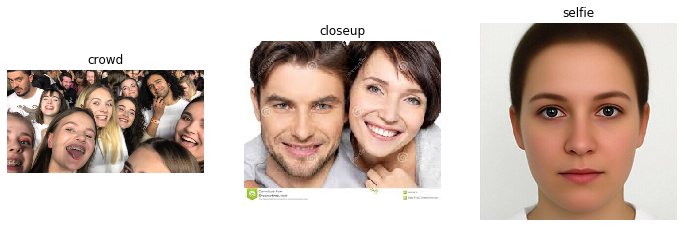

In [3]:
fig = plt.figure(figsize=(12,5))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath,)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(image ) 
    ax.axis('off')
plt.show()    

# [ 모델 준비하기 ]
---


## 1. 모델 불러오기 

In [4]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
import tensorflow as tf

class L2Normalization(Layer):
    def build(self, input_shape):
        self.gamma = self.add_weight(
            name='gamma', shape=(input_shape[-1],))
        super().build(input_shape)
        
    def call(self, inputs):
        output = K.l2_normalize(inputs, -1)
        return output * self.gamma
    
    
class DecodeBoxes(Layer):
    def __init__(self, 
                 box_step, 
                 box_sizes, 
                 variance=[0.1,0.1,0.2,0.2],
                 image_size=(300,300), 
                 **kwargs):
        self.box_step = box_step
        self.box_sizes = box_sizes
        self.variance = variance
        self.image_size = image_size
        super().__init__(**kwargs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "box_step": self.box_step,
            "box_sizes": self.box_sizes,
            "variance": self.variance,
            "image_size": self.image_size})
        return config    
    
    def call(self, inputs):
        variance = tf.constant(self.variance, tf.float32)
        delta_boxes = inputs[...,:4] * variance
        confidence = inputs[..., 5:]
        
        # 각 Grid 별 prior box의 중심 좌표 구하기
        ys = tf.range(0, self.image_size[0], self.box_step, tf.float32)
        ys = ys + self.box_step / 2.
        ys = ys / self.image_size[0]

        xs = tf.range(0, self.image_size[1], self.box_step, tf.float32)
        xs = xs + self.box_step / 2.
        xs = xs / self.image_size[1]
        prior_cx, prior_cy = tf.meshgrid(xs, ys)

        results = []
        for idx, box_size in enumerate(self.box_sizes):
            # 각 Grid 별 prior box의 Width, Height 구하기
            prior_w = tf.ones_like(prior_cx) * box_size[0] / self.image_size[1]
            prior_h = tf.ones_like(prior_cy) * box_size[1] / self.image_size[0]

            target_delta_boxes = delta_boxes[:,:,:,idx]
            d_cx, d_cy, d_w, d_h = tf.unstack(target_delta_boxes, axis=-1)

            decoded_cx = d_cx * prior_w + prior_cx
            decoded_cy = d_cy * prior_h + prior_cy
            decoded_w = tf.exp(d_w) * prior_w
            decoded_h = tf.exp(d_h) * prior_h

            decoded_xmin = decoded_cx - decoded_w / 2
            decoded_ymin = decoded_cy - decoded_h / 2
            decoded_xmax = decoded_cx + decoded_w / 2
            decoded_ymax = decoded_cy + decoded_h / 2        
            result = tf.stack(
                [decoded_xmin, decoded_ymin, 
                 decoded_xmax, decoded_ymax],axis=-1)
            results.append(result)

        boxes = tf.stack(results, axis=3)
        return tf.concat([boxes, confidence], axis=-1)            

In [5]:
from tensorflow.keras.layers import Reshape, Concatenate
from tensorflow.keras.models import load_model, Model

K.clear_session()

fpath = get_file('SSD_face_detector.h5',
                 'https://pai-datasets.s3.ap-northeast-2.amazonaws.com/face-recognition/SSD_face_detector.h5')
model = load_model(fpath, compile=False,
                   custom_objects={'L2Normalization': L2Normalization})


level0_priors = [[30., 30.], 
                 [42.426, 42.426], 
                 [42.426, 21.213],
                 [21.213, 42.426]]
level0_step = 8
level0_out = DecodeBoxes(level0_step, level0_priors)(model.output[0])

level1_priors = [[ 60.   ,  60.   ],
                 [ 81.608,  81.608],
                 [ 84.853,  42.426],
                 [ 42.426,  84.853],
                 [103.923,  34.641],
                 [ 34.641, 103.923]]
level0_step = 16
level1_out = DecodeBoxes(level0_step, level1_priors)(model.output[1])

level2_priors = [[111.   , 111.   ],
                 [134.097, 134.097],
                 [156.978,  78.489],
                 [ 78.489, 156.978],
                 [192.258,  64.086],
                 [ 64.086, 192.258]]
level2_step = 32
level2_out = DecodeBoxes(level2_step, level2_priors)(model.output[2])

level3_priors = [[162.   , 162.   ],
                 [185.758, 185.758],
                 [229.103, 114.551],
                 [114.551, 229.103],
                 [280.592,  93.531],
                 [ 93.531, 280.592]]
level3_step = 64
level3_out = DecodeBoxes(level3_step, level3_priors)(model.output[3])

level4_priors = [[213.   , 213.   ],
                 [237.133, 237.133],
                 [301.227, 150.614],
                 [150.614, 301.227]]
level4_step = 100
level4_out = DecodeBoxes(level4_step, level4_priors)(model.output[4])

level5_priors = [[264.   , 264.   ],
                 [288.375, 288.375],
                 [373.352, 186.676],
                 [186.676, 373.352]]
level5_step = 300
level5_out = DecodeBoxes(level5_step, level5_priors)(model.output[5])

level0_reshaped = Reshape((-1,5))(level0_out)
level1_reshaped = Reshape((-1,5))(level1_out)
level2_reshaped = Reshape((-1,5))(level2_out)
level3_reshaped = Reshape((-1,5))(level3_out)
level4_reshaped = Reshape((-1,5))(level4_out)
level5_reshaped = Reshape((-1,5))(level5_out)

predictions = Concatenate(axis=1)([level0_reshaped, level1_reshaped, 
                                   level2_reshaped, level3_reshaped, 
                                   level4_reshaped, level5_reshaped])

inference = Model(model.inputs, predictions)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## 2. 모델 추론 결과 시각화

### (1) 입력값 전처리하기

In [6]:
def preprocess_image(image):    
    # resize image
    image = cv2.resize(image, (300, 300))
    
    # 1. RGB to BGR
    image = image[:,:,::-1]
    
    # 2. subtract mean
    image = image - np.array((104.0, 177.0, 123.0))
    
    # 3. add batch axis
    image = image[None]
    
    return image

### (2) 결과 시각화하기

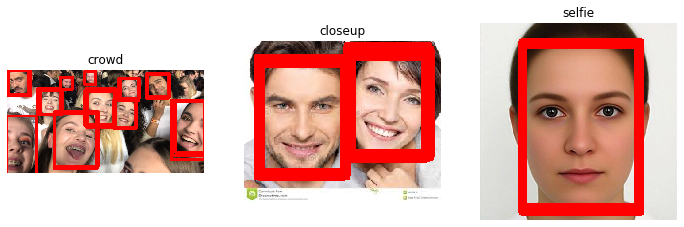

In [7]:
fig = plt.figure(figsize=(12,8))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    keras_input = preprocess_image(image)

    result = inference.predict(keras_input)
    h, w = image.shape[:2]
    vis = image.copy()
    for box in result[result[...,-1]>0.3]:
        minx, miny, maxx, maxy = (box[:4] * [w, h, w, h]).astype(np.int)
        cv2.rectangle(vis, (minx, miny), (maxx, maxy), (255,0,0), 10)
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(vis)
    ax.axis('off')
plt.show()

# [ 중첩된 결과를 합치는 Non-Maximum Suppression] 
---

Non-Maximum Suppression의 알고리즘은 심플합니다. 하나씩 박스를 꺼내서 해당 박스와 특정값 이상(예 50% 이상) 겹치면 제거해주는 알고리즘입니다. 
![Imgur](https://i.imgur.com/NsppxPr.png)

## 1. 알고리즘 구현하기

In [8]:
def non_maximum_suppression(boxes, confs, overlap_threshold=0.3):
    pick = []
    x1, y1, x2, y2 = boxes.T
    
    indices = np.argsort(confs)[::-1]
    area = (x2 - x1) * (y2 - y1)
    
    while len(indices) > 0:
        idx, indices = indices[0], indices[1:]
        pick.append(idx)

        xx1 = np.maximum(x1[idx], x1[indices])
        yy1 = np.maximum(y1[idx], y1[indices])
        xx2 = np.minimum(x2[idx], x2[indices])
        yy2 = np.minimum(y2[idx], y2[indices])
        
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        
        intersection = w * h
        union = area[indices] + area[idx] - intersection
        overlap = intersection/(union+1e-8)
        
        indices = indices[overlap <= overlap_threshold]
    return pick

## 2. 알고리즘 적용하기

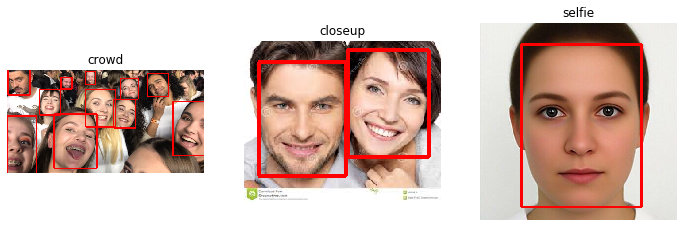

In [9]:
fig = plt.figure(figsize=(12,8))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    keras_input = preprocess_image(image)

    keras_output = inference.predict(keras_input)
    boxes = keras_output[0,:,:4]
    confs = keras_output[0,:,-1]
    
    pick_indices = non_maximum_suppression(boxes, confs)
    chosen_outputs = keras_output[0,pick_indices]
    
    h, w = image.shape[:2]
    vis = image.copy()
    for box in chosen_outputs[chosen_outputs[:,-1]>0.3]:
        minx, miny, maxx, maxy = (box[:4] * [w, h, w, h]).astype(np.int)
        cv2.rectangle(vis, (minx, miny), (maxx, maxy), (255,0,0), 3)
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(vis)
    ax.axis('off')
plt.show()

# [ Optional ] OpenCV에서의 Face Detector
---

OpenCV에서도 동일한 모델(SSD)이 존재합니다. OpenCV에서는 기본적으로 `CaFFE`라 불리는 API를 기준으로 작성되어 있습니다.

### (1) 모델 불러오기

In [10]:
# 모형 불러오기
proto_path = get_file("deploy.prototxt",
                      "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/face-recognition/deploy.prototxt")
model_path = get_file("res10_300x300_ssd_iter_140000_fp16.caffemodel",
                      "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/face-recognition/res10_300x300_ssd_iter_140000_fp16.caffemodel")

net = cv2.dnn.readNetFromCaffe(proto_path, model_path)

5357568/5351047 [==============================] - 0s 0us/step


### (2) 데이터 전처리하기

In [11]:
def preprocess_image_for_cv2(image):
    image = image[...,::-1]
    blob = cv2.dnn.blobFromImage(
        cv2.resize(image, (300, 300)), 1.0, 
        (300, 300), (104.0, 177.0, 123.0))
    return blob

In [12]:
image = cv2.imread(fpaths['crowd'])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

blob = preprocess_image_for_cv2(image)

### (3) 추론하기

In [13]:
net.setInput(blob)
detections = net.forward()
detections

array([[[[0.   , 1.   , 0.997, ..., 0.433, 0.457, 0.953],
         [0.   , 1.   , 0.979, ..., 0.291, 0.652, 0.568],
         [0.   , 1.   , 0.971, ..., 0.197, 0.549, 0.557],
         ...,
         [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
         [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]]], dtype=float32)

### (4) 시각화하기

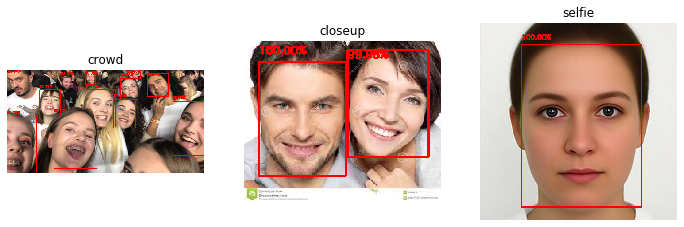

In [14]:
fig = plt.figure(figsize=(12,5))
for idx, (title, fpath) in enumerate(fpaths.items(),1):
    image = cv2.imread(fpath,)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    blob = preprocess_image_for_cv2(image)
    net.setInput(blob)
    detections = net.forward()
    
    h, w = image.shape[:2]    
    
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.2:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int") 
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY), (255,0,0), 2)
            cv2.putText(image, text, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,0,0), 2)
    
    
    ax = fig.add_subplot(1,3,idx)
    ax.set_title(title)
    ax.imshow(image ) 
    ax.axis('off')
plt.show()    

#  

---

    Copyright(c) 2020 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2020/03/19

---